# Accuracy Evaluation

Evaluation of accuracy measures on a large benchmark of data series.

In [1]:
import json
import ast
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import time



In [2]:
all_file_folder = {}
for folder in os.listdir('/Users/boniolp/Downloads/benchmark/'):
    all_files = [] 
    if "." not in folder:
        for file in os.listdir('/Users/boniolp/Downloads/benchmark/{}/'.format(folder)):
            all_files.append('{}.out_acc.txt'.format(file.split('.out')[0]))
        all_file_folder[folder] = all_files


In [3]:
all_files = []
for file in os.listdir('../../results/acc_eval/'):
    all_files.append(file)

In [4]:
def generate_dict(list_file):
    all_dict = []
    listname = []
    res_dir = '../../results/acc_eval/'
    for file_s in os.listdir(res_dir):
        if file_s in list_file:
            f  = ast.literal_eval(open(res_dir+file_s).read()[:-1])
            all_dict.append(f)
            listname.append(file_s)
    return all_dict,listname


all_dict_per_dataset = {}
all_dict_per_dataset_files = {}
for folder in all_file_folder.keys():
    all_dict,listname = generate_dict(all_file_folder[folder])
    if len(all_dict) > 0:
        all_dict_per_dataset[folder] = all_dict
        all_dict_per_dataset_files[folder] = listname

In [5]:
from scipy.interpolate import make_interp_spline
from scipy.stats import entropy
from math import log, e


def pandas_entropy(df, base=None):
    res = {}
    for column in df.columns:
        vc = pd.Series(df[column]).value_counts(normalize=True, sort=False)
        base = e if base is None else base
        res[column] = -(vc * np.log(vc)/np.log(base)).sum()
    return res

def compute_table(all_dict,listname,metric):
    res = {}
    for dict_s,name in zip(all_dict,listname):
        res[name] = {}
        for method in dict_s.keys():
            res[name][method] = np.mean(dict_s[method][metric])
    return res


def compute_table_std(all_dict,listname,metric):
    res = {}
    for dict_s,name in zip(all_dict,listname):
        res[name] = {}
        for method in dict_s.keys():
            res[name][method] = np.std(dict_s[method][metric])
    return res

# Accuracy Analysis on KDD21

Exports of accuracy tables for KDD21 dataset. Critical diagram are computed using these exports.

In [6]:
#dataset = 'KDD21'
metrics = ['VUS_ROC','VUS_PR','R_AUC_ROC','R_AUC_PR','AUC_ROC','AUC_PR','RF','F','Rprecision','Rrecall','Precision','Recall','Precision@k'][::-1]

#for i,metric in enumerate(metrics):
#    pd.DataFrame(write_pairtwise_test(pd.DataFrame(compute_table(all_dict_per_dataset[dataset],all_dict_per_dataset_files["KDD21"],metric)).T),columns=['classifier_name','dataset_name','accuracy']).to_csv('/Users/boniolp/Desktop/LIPADE/cd-diagram/vus_acc/{}_pairwise.csv'.format(metric),index=False)


#pd.DataFrame(compute_table(all_dict_per_dataset[dataset],all_dict_per_dataset_files[dataset],'Precision')).T

# Rank and Entropy Analysis

Analysis of the ranks and the entropy of the ranks of each methods.

In [7]:
folder_all_res = []
folder_all_res_values = []
folder_all_res_std = []

all_folder_print = ['IOPS', 'MGAB', 'ECG', 'SensorScope', 'NASA-MSL', 'KDD21', 'NASA-SMAP', 'NAB', 'YAHOO']


metrics = ['VUS_ROC','VUS_PR','R_AUC_ROC','R_AUC_PR','AUC_ROC','AUC_PR','RF','F','Rprecision','Rrecall','Precision','Recall','Precision@k'][::-1]
for folder in all_folder_print:
    all_res = pd.DataFrame(index=metrics,columns=list(all_dict_per_dataset[folder][0].keys())).T
    all_res_std = pd.DataFrame(index=metrics,columns=list(all_dict_per_dataset[folder][0].keys())).T
    all_res_values = pd.DataFrame(index=metrics,columns=list(all_dict_per_dataset[folder][0].keys())).T
    for metric in metrics:
        all_res[metric] = pd.DataFrame(compute_table(all_dict_per_dataset[folder],all_dict_per_dataset_files[folder],metric)).rank(ascending=False).T.mean().values
        all_res_values[metric] = pd.DataFrame(compute_table(all_dict_per_dataset[folder],all_dict_per_dataset_files[folder],metric)).T.mean().values
        all_res_std[metric] = pandas_entropy(pd.DataFrame(compute_table(all_dict_per_dataset[folder],all_dict_per_dataset_files[folder],metric)).rank(ascending=False).T).values()
        #all_res_std[metric] = pd.DataFrame(compute_table(all_dict_per_dataset[folder],all_dict_per_dataset_files[folder],metric)).rank(ascending=False).T.std().values
    folder_all_res.append(all_res)
    folder_all_res_std.append(all_res_std)
    folder_all_res_values.append(all_res_values)



In [8]:
mean_folder_all_res = pd.DataFrame(columns=metrics,index=list(all_dict_per_dataset['IOPS'][0].keys()))
mean_folder_all_res_values = pd.DataFrame(columns=metrics,index=list(all_dict_per_dataset['IOPS'][0].keys()))
mean_folder_all_res_std = pd.DataFrame(columns=metrics,index=list(all_dict_per_dataset['IOPS'][0].keys()))
mean_mat = np.mean([f.values for f in folder_all_res],0).T
mean_mat_values = np.mean([f.values for f in folder_all_res_values],0).T
mean_mat_std = np.mean([f.values for f in folder_all_res_std],0).T
for mean_row,mean_row_std,mean_row_values,metric in zip(mean_mat,mean_mat_std,mean_mat_values,metrics):
    mean_folder_all_res[metric] = mean_row
    mean_folder_all_res_std[metric] = mean_row_std
    mean_folder_all_res_values[metric] = mean_row_values
mean_folder_all_res

,Precision@k,Recall,Precision,Rrecall,Rprecision,F,RF,AUC_PR,AUC_ROC,R_AUC_PR,R_AUC_ROC,VUS_PR,VUS_ROC
NormA,4.210485,4.249889,4.787366,4.559922,4.463738,4.425060,4.650611,4.253773,4.103623,4.298602,4.379906,4.293008,4.300858
POLY,5.384482,4.903971,4.994008,5.109559,4.855465,4.920786,5.006390,4.686958,4.704703,4.535406,5.050737,4.473394,4.983283
IForest,5.042205,5.114203,5.075445,5.849549,4.820506,5.103598,5.547707,4.540955,4.301471,4.570341,4.406066,4.621100,4.406458
AE,4.880552,4.953687,4.640731,5.279224,4.740862,4.838507,4.919577,4.913290,4.825540,4.842853,4.684716,4.847660,4.650359
OCSVM,5.697530,5.753513,5.064816,5.559130,5.503605,5.595893,5.493684,5.454006,5.501606,5.324205,5.368112,5.321574,5.449086
MatrixProfile,5.145945,5.191028,5.589128,5.379395,5.707388,5.390321,5.671893,5.565779,5.264788,5.136523,5.087060,5.196917,5.173278
LOF,4.661508,4.706821,4.491874,4.760564,4.481798,4.699444,4.886699,4.648609,4.715578,3.911382,4.209517,3.944675,4.308522
LSTM,5.089040,5.163219,5.363024,4.345831,5.339533,5.122215,4.496773,5.705758,6.162379,6.581456,6.348949,6.559446,6.288700
CNN,4.888253,4.963668,4.993608,4.156825,5.087105,4.904176,4.326666,5.230872,5.420312,5.799231,5.464937,5.742226,5.439456


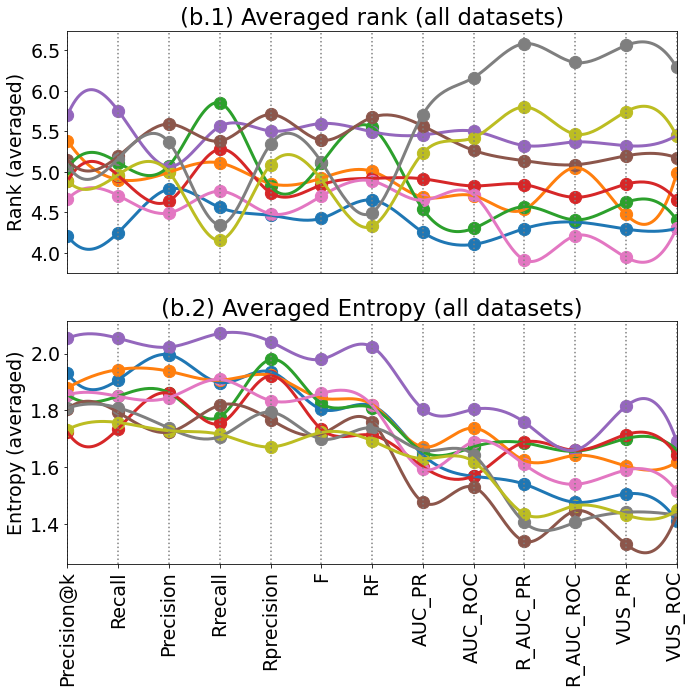

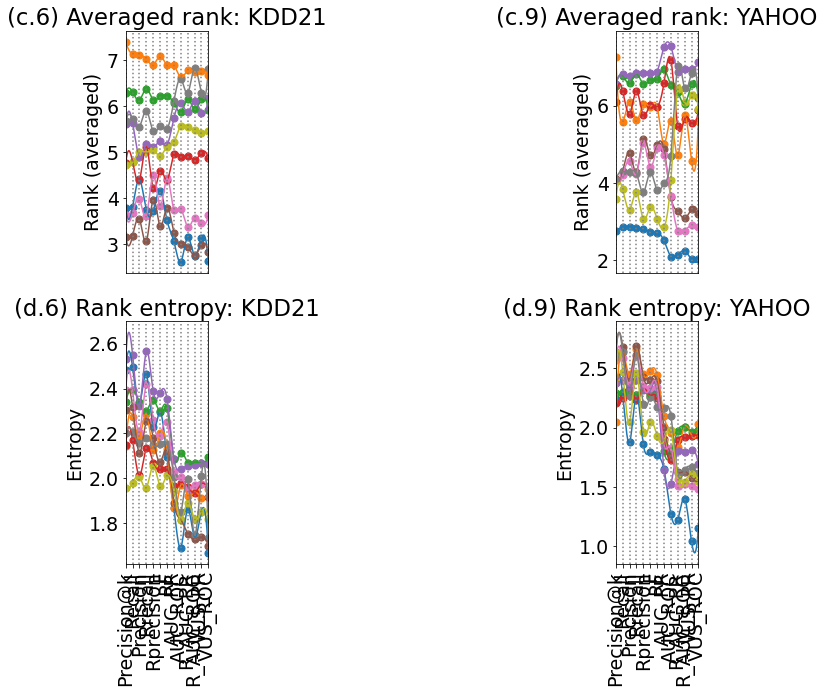

In [9]:
from scipy.interpolate import make_interp_spline

plt.rcParams.update({'font.size': 19})

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("(b.1) Averaged rank (all datasets)")
for i,name in zip(range(len(np.array(mean_folder_all_res))),list(mean_folder_all_res.index)):
    xnew = np.linspace(0, len(np.array(mean_folder_all_res)[i])-1, 300)
    interpol = make_interp_spline(list(range(len(np.array(mean_folder_all_res)[i]))), np.array(mean_folder_all_res)[i], k=3)
    ynew = interpol(xnew)
    plt.scatter(list(range(len(np.array(mean_folder_all_res)[i]))),np.array(mean_folder_all_res)[i],s=150)
    plt.plot(xnew,ynew,linewidth=3,label=name)
for pos in list(range(len(np.array(mean_folder_all_res)[i]))):
    plt.axvline(pos,color='grey',linestyle='dotted')
plt.xlim(0,len(np.array(mean_folder_all_res)[i])-1)
plt.xticks([],[])
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Rank (averaged)')

plt.subplot(2,1,2)
plt.title("(b.2) Averaged Entropy (all datasets)")
for i in range(len(np.array(mean_folder_all_res_std))):
    xnew = np.linspace(0, len(np.array(mean_folder_all_res_std)[i])-1, 300)
    interpol = make_interp_spline(list(range(len(np.array(mean_folder_all_res_std)[i]))), np.array(mean_folder_all_res_std)[i], k=3)
    ynew = interpol(xnew)
    plt.scatter(list(range(len(np.array(mean_folder_all_res_std)[i]))),np.array(mean_folder_all_res_std)[i],s=150)
    plt.plot(xnew,ynew,linewidth=3)
for pos in list(range(len(np.array(mean_folder_all_res_std)[i]))):
    plt.axvline(pos,color='grey',linestyle='dotted')
plt.xlim(0,len(np.array(mean_folder_all_res_std)[i])-1)
plt.xticks(list(range(len(metrics))),metrics,rotation=90)
plt.ylabel('Entropy (averaged)')

plt.tight_layout()

all_folder_to_keep = ['KDD21', 'YAHOO']

plt.figure(figsize=(20,10))
for j,(folder,folder_std) in enumerate(zip(folder_all_res,folder_all_res_std)):
    if all_folder_print[j] in all_folder_to_keep:
        plt.subplot(2,len(folder_all_res),j+1)
        plt.title("(c.{}) Averaged rank: {}".format(j+1,all_folder_print[j]))
        for i in range(len(np.array(folder))):
            xnew = np.linspace(0, len(np.array(folder)[i])-1, 300)
            interpol = make_interp_spline(list(range(len(np.array(folder)[i]))), np.array(folder)[i], k=3)
            ynew = interpol(xnew)
            plt.scatter(list(range(len(np.array(folder)[i]))),np.array(folder)[i],s=50)
            plt.plot(xnew,ynew)
        for pos in list(range(len(np.array(folder)[i]))):
            plt.axvline(pos,color='grey',linestyle='dotted')
        plt.xlim(0,len(np.array(folder)[i])-1)
        plt.xticks([],[])
        plt.ylabel('Rank (averaged)')
plt.tight_layout()

#plt.figure(figsize=(30,8))
for j,(folder,folder_std) in enumerate(zip(folder_all_res,folder_all_res_std)):
    if all_folder_print[j] in all_folder_to_keep:
        plt.subplot(2,len(folder_all_res),j+1+len(folder_all_res))
        plt.title("(d.{}) Rank entropy: {}".format(j+1,all_folder_print[j]))
        for i in range(len(np.array(folder))):
            xnew = np.linspace(0, len(np.array(folder_std)[i])-1, 300)
            interpol = make_interp_spline(list(range(len(np.array(folder_std)[i]))), np.array(folder_std)[i], k=3)
            ynew = interpol(xnew)
            plt.scatter(list(range(len(np.array(folder_std)[i]))),np.array(folder_std)[i],s=50)
            plt.plot(xnew,ynew)
        for pos in list(range(len(np.array(folder_std)[i]))):
            plt.axvline(pos,color='grey',linestyle='dotted')
        plt.xlim(0,len(np.array(folder)[i])-1)
        plt.xticks(list(range(len(metrics))),metrics,rotation=90)
        plt.ylabel('Entropy')
plt.tight_layout()

In [18]:
mean_folder_all_res_std.mean()

Precision@k    1.849162
Recall         1.855681
Precision      1.857076
Rrecall        1.839631
Rprecision     1.874456
F              1.798386
RF             1.799163
AUC_PR         1.637622
AUC_ROC        1.648384
R_AUC_PR       1.565399
R_AUC_ROC      1.550153
VUS_PR         1.570454
VUS_ROC        1.539295
dtype: float64

<ipython-input-10-17d184d883e0>:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


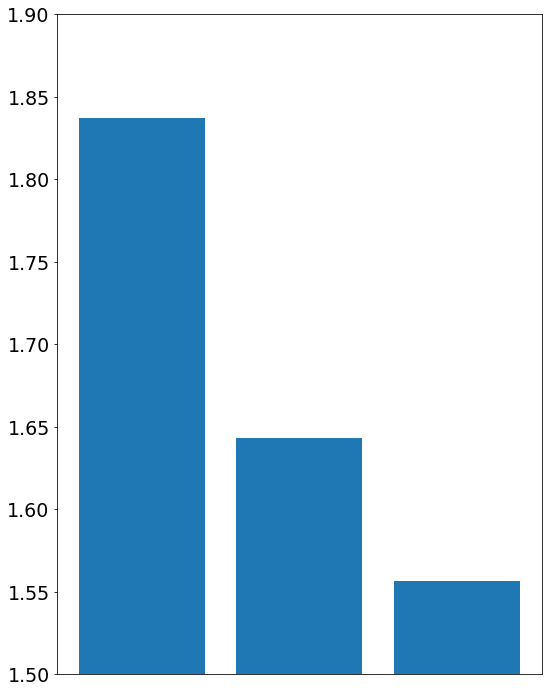

In [10]:
mean_entrop = np.mean(np.mean([f.values for f in folder_all_res_std],0),0)[::-1]

mean_VUS = np.mean([mean_entrop[0],mean_entrop[1],mean_entrop[2],mean_entrop[3]])
#mean_RANGE_AUC = np.mean([mean_entrop[2],mean_entrop[3]])
mean_AUC = np.mean([mean_entrop[4],mean_entrop[5]])
mean_threshold_based = np.mean(mean_entrop[6:-1])

all_mean = [mean_VUS,mean_AUC,mean_threshold_based][::-1]#[mean_VUS,mean_RANGE_AUC,mean_AUC,mean_threshold_based][::-1]
all_mean_name = ["Range and VUS-based","AUC","threshold \n based"][::-1]

plt.figure(figsize=(8,10))
plt.bar(all_mean_name,all_mean)
plt.ylim(1.5,1.9)
#plt.ylabel("Averaged Entropy")
#plt.title("(a) Average of the rank entropy \n for categories of measures")
plt.xticks([])
plt.tight_layout()

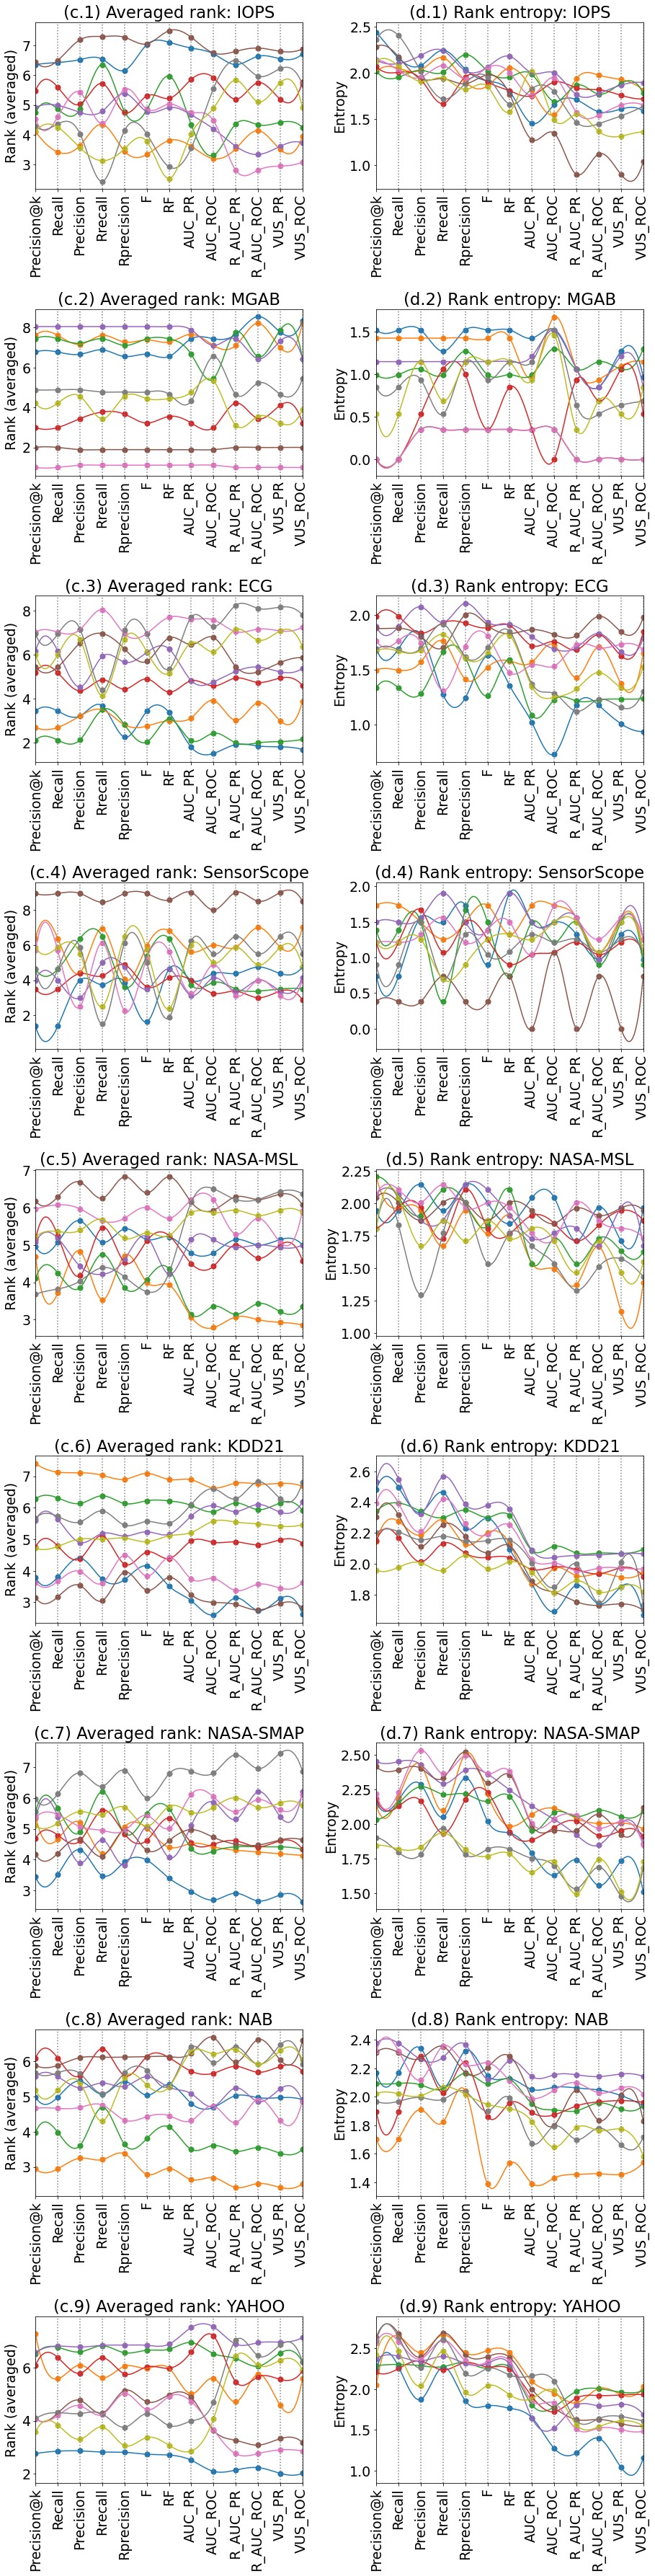

In [11]:
from scipy.interpolate import make_interp_spline

plt.rcParams.update({'font.size': 19})

def plot_entropy(all_folder_print,folder,folder_std,metrics):
    plt.title("(d.{}) Rank entropy: {}".format(j+1,all_folder_print[j]))
    for i in range(len(np.array(folder))):
        xnew = np.linspace(0, len(np.array(folder_std)[i])-1, 300)
        interpol = make_interp_spline(list(range(len(np.array(folder_std)[i]))), np.array(folder_std)[i], k=3)
        ynew = interpol(xnew)
        plt.scatter(list(range(len(np.array(folder_std)[i]))),np.array(folder_std)[i],s=50)
        plt.plot(xnew,ynew)
    for pos in list(range(len(np.array(folder_std)[i]))):
        plt.axvline(pos,color='grey',linestyle='dotted')
    plt.xlim(0,len(np.array(folder)[i])-1)
    plt.xticks(list(range(len(metrics))),metrics,rotation=90)
    plt.ylabel('Entropy')

    
def plot_rank(all_folder_print,folder,folder_std,metrics):
    plt.title("(c.{}) Averaged rank: {}".format(j+1,all_folder_print[j]))
    for i in range(len(np.array(folder))):
        xnew = np.linspace(0, len(np.array(folder)[i])-1, 300)
        interpol = make_interp_spline(list(range(len(np.array(folder)[i]))), np.array(folder)[i], k=3)
        ynew = interpol(xnew)
        plt.scatter(list(range(len(np.array(folder)[i]))),np.array(folder)[i],s=50)
        plt.plot(xnew,ynew)
    for pos in list(range(len(np.array(folder)[i]))):
        plt.axvline(pos,color='grey',linestyle='dotted')
    plt.xlim(0,len(np.array(folder)[i])-1)
    plt.xticks(list(range(len(metrics))),metrics,rotation=90)
    plt.ylabel('Rank (averaged)')

all_folder_to_keep = all_folder_print

plt.figure(figsize=(13,50))
for j,(folder,folder_std) in enumerate(zip(folder_all_res,folder_all_res_std)):
    if all_folder_print[j] in all_folder_to_keep:
        plt.subplot(len(all_folder_to_keep),2,2*(j)+1)
        plot_rank(all_folder_print,folder,folder_std,metrics)
        plt.subplot(len(all_folder_to_keep),2,2*(j)+2)
        plot_entropy(all_folder_print,folder,folder_std,metrics)
plt.tight_layout()